In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from itertools import product
from sklearn.metrics import precision_recall_curve


In [2]:
PATH = '../train/train_df.csv'
train_df = pd.read_csv(PATH) 
PATH = '../test/test_df.csv'
test_df = pd.read_csv(PATH)

In [3]:
X_train,  y_train,  = train_df['text'], train_df['label']
X_test, y_test = test_df['text'], test_df['label']

### Use pipeline perform the cross validation to select the best combination of the parameters


In [7]:

# since from the EDA we find the imbalance data issue, here we change the weight of different classes
class_weights = {0: 4, 1: 5, 2: 1}  # 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', OneVsRestClassifier(SVC(probability=True, class_weight=class_weights)))
])

param_values = {
    'classifier__estimator__C': [0.1, 1],
    'classifier__estimator__kernel': [ 'rbf'],
    'classifier__estimator__gamma': [ 1 ,10],
}
# Generate all combinations of hyperparameters
param_combinations = list(product(*param_values.values()))

# Track the best hyperparameters and their performance
best_params = None
best_avg_accuracy = 0.0  # Initialize with a low value

# Iterate through hyperparameter combinations
for param_set in param_combinations:
    # Assign hyperparameter values to the pipeline
    param_dict = dict(zip(param_values.keys(), param_set))
    pipeline.set_params(**param_dict)

    # Track performance metrics across folds
    accuracy_list = []

    # Evaluate the model using k-fold cross-validation
    for fold, (_, test_index) in enumerate(cv.split(X_train, y_train)):
        X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

        # Fit the model on the training data for this fold
        pipeline.fit(X_train, y_train)

        # Get the model's accuracy on the test set for this fold
        y_pred = pipeline.predict(X_fold_test)
        accuracy_fold = accuracy_score(y_fold_test, y_pred)
        accuracy_list.append(accuracy_fold)

    # Calculate the average accuracy across all folds for this parameter set
    avg_accuracy = np.mean(accuracy_list)

    # Update the best hyperparameters if the current set performs better
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_params = param_set

print("Best Hyperparameters:", best_params)
print("Best Average Accuracy:", best_avg_accuracy)

In [9]:
class_weights = {0: 4, 1: 5, 2: 1}  # 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', OneVsRestClassifier(SVC(probability=True, class_weight=class_weights)))
])

* save the trained best model

In [ ]:
import pickle
# Assuming best_model is your trained Pipeline
with open('SVM_best_model.pkl', 'wb') as file:
    pickle.dump(best_params, file)

### Test part
* In this part using k fold cross validation 
* Use pickle to load the trained data in pkl

In [5]:
import pickle

with open('SVM_best_model.pkl', 'rb') as file:
    best_params = pickle.load(file)

In [4]:
class_weights = {0: 4, 1: 5, 2: 1}  # Adjust based on your data


# Define the pipeline with TfidfVectorizer and OneVsRestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', OneVsRestClassifier(SVC(probability=True, class_weight=class_weights)))
])

# Define hyperparameter values to try
param_values = {
    'classifier__estimator__C': [0.1,1],
    'classifier__estimator__kernel': [ 'rbf'],
    'classifier__estimator__gamma': [ 1 ,10],
}

In [6]:
from sklearn.metrics import classification_report, accuracy_score

# Set the best hyperparameters to the pipeline
best_param_dict = dict(zip(param_values.keys(), best_params))
pipeline.set_params(**best_param_dict)

# Train the final model on the entire training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
# Print the final model evaluation metrics
print("Test Accuracy:", accuracy)
print("Test Classification Report:\n", class_report)


Test Accuracy: 0.841
Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79       758
           1       0.47      0.13      0.20       448
           2       0.86      0.98      0.91      2794

    accuracy                           0.84      4000
   macro avg       0.72      0.62      0.64      4000
weighted avg       0.81      0.84      0.81      4000



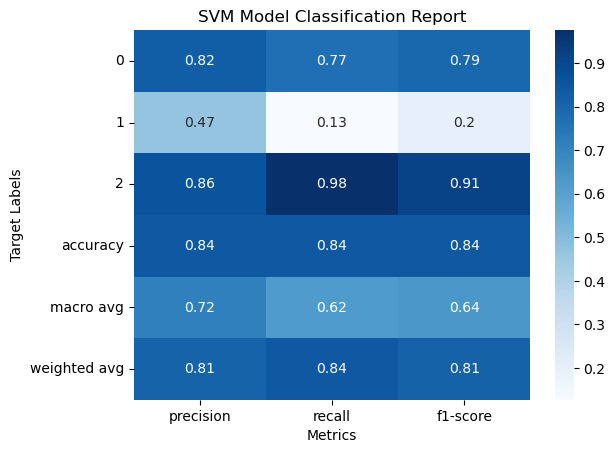

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

report_dict = classification_report(y_test, y_pred_test, output_dict=True)

sns.heatmap(pd.DataFrame(report_dict).iloc[:-1, :].T, annot=True, cmap="Blues")

plt.xlabel("Metrics")
plt.ylabel("Target Labels")
plt.title("SVM Model Classification Report")

plt.show()

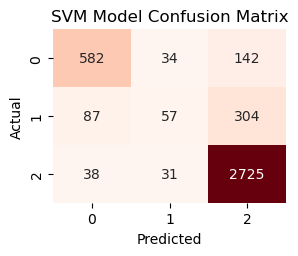

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(3, 2.25))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.title('SVM Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


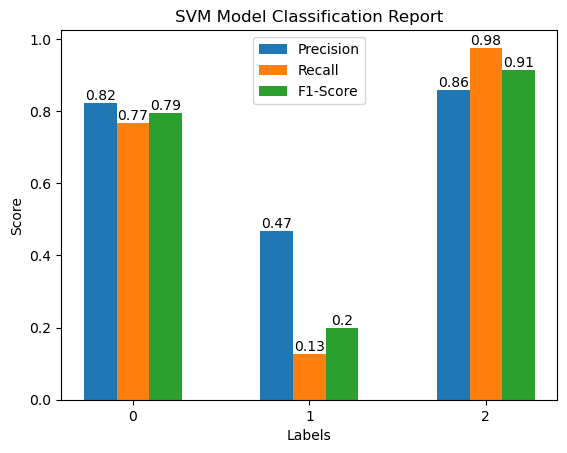

In [9]:
labels = [label for label in report_dict.keys() if label not in ('accuracy', 'macro avg', 'weighted avg')]
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

x = range(len(labels))
width = 0.185

plt.bar(x, precision, width, label='Precision')
plt.bar([i + width for i in x], recall, width, label='Recall')
plt.bar([i + 2 * width for i in x], f1_score, width, label='F1-Score')
for i, val in enumerate(precision):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')
for i, val in enumerate(recall):
    plt.text(i+width, val, round(val, 2), ha='center', va='bottom')
for i, val in enumerate(f1_score):
    plt.text(i+2*width, val, round(val, 2), ha='center', va='bottom')
plt.xlabel('Labels')
plt.ylabel('Score')
plt.title('SVM Model Classification Report')

plt.xticks([i + width for i in x], labels)
plt.legend(loc='upper center')

plt.show()


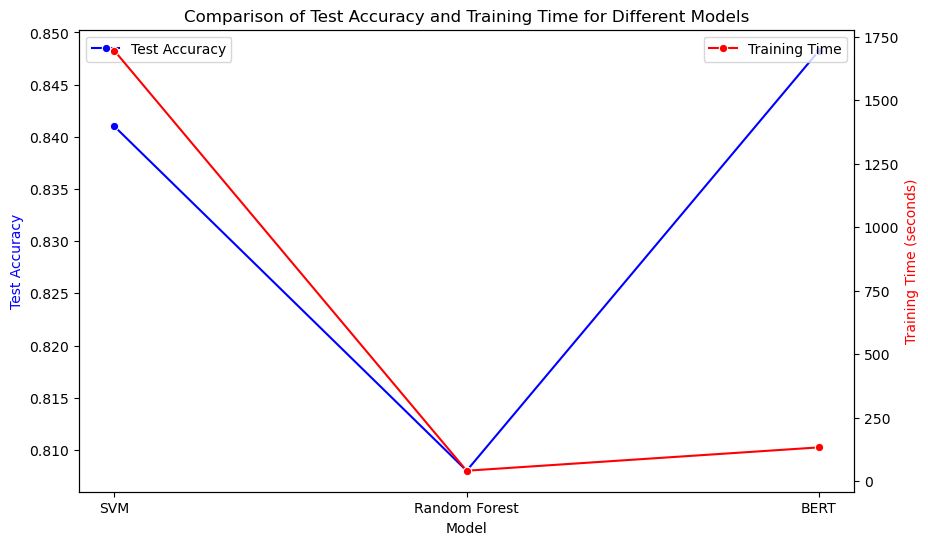

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ['SVM', 'Random Forest', 'BERT']
test_accuracy = [0.841, 0.808, 0.84825]
training_time = [1695.1, 41.4, 133.3]

# Create a DataFrame
import pandas as pd
df = pd.DataFrame({'Model': models, 'Test Accuracy': test_accuracy, 'Training Time': training_time})

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for Test Accuracy
sns.lineplot(x='Model', y='Test Accuracy', data=df, ax=ax1, marker='o', label='Test Accuracy', color='b')

# Line plot for Training Time
ax2 = ax1.twinx()
sns.lineplot(x='Model', y='Training Time', data=df, ax=ax2, marker='o', label='Training Time', color='r')

# Set labels and title
ax1.set_ylabel('Test Accuracy', color='b')
ax2.set_ylabel('Training Time (seconds)', color='r')
ax1.set_xlabel('Model')
plt.title('Comparison of Test Accuracy and Training Time for Different Models')

# Show the plot
plt.show()
